# Introduction
This notebook reproduces the results presented in *nanoTabPFN: A Lightweight and Educational Reimplementation of TabPFN*.


# Imports

In [18]:
from matplotlib import pyplot as plt
import functools
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import numpy as np
import openml
import pandas as pd
from openml.tasks import TaskType
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, FunctionTransformer 
import random
import torch

## Creating our own h5 training and evaluation files compatible with the dataloader

In [2]:
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import openml

In [3]:
import importlib
import preprocessing
importlib.reload(preprocessing) #il faut reload l'importer des que tu fais un changement a la classe

<module 'preprocessing' from 'c:\\Users\\gregg\\OneDrive\\Desktop\\Salome\\Neuralk_NanoTabFPN\\preprocessing.py'>

In [4]:
from preprocessing import create_h5_prior_from_dataset

Create the files

In [5]:
# create a h5 file with 10000 tasks sampled randomly from the forest coverage database
# one file with tasks of 100 rows, one file with tasks of 500 rows
create_h5_prior_from_dataset(1596, "h5_files/10k_covertype_database_100_80_rows_10_features.h5", num_tasks = 10000, total_rows = 100, train_rows=80, num_features=8)
create_h5_prior_from_dataset(1596, "h5_files/10k_covertype_database_500_400_rows_8_features.h5", num_tasks = 10000, total_rows = 500, train_rows=40, num_features=8)

c:\Users\gregg\OneDrive\Desktop\Salome\Neuralk_NanoTabFPN\preprocessing.py:12: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)
Could not download file from https://openml.org/datasets/0000/1596/dataset_1596.pq: HTTPSConnectionPool(host='www.openml.org', port=443): Max retries exceeded with url: https://www.openml.org/datasets/0000/1596/dataset_1596.pq (Caused by ResponseError('too many redirects'))


table size =  (581012, 54)
Saved tasks here here  to h5_files/10k_covertype_database_100_80_rows_10_features.h5


c:\Users\gregg\OneDrive\Desktop\Salome\Neuralk_NanoTabFPN\preprocessing.py:12: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)
Could not download file from https://openml.org/datasets/0000/1596/dataset_1596.pq: HTTPSConnectionPool(host='www.openml.org', port=443): Max retries exceeded with url: https://www.openml.org/datasets/0000/1596/dataset_1596.pq (Caused by ResponseError('too many redirects'))


table size =  (581012, 54)
Saved tasks here here  to h5_files/10k_covertype_database_500_400_rows_8_features.h5


In [55]:
# create smaller file
#create_h5_prior_from_dataset(1596, "h5_files/500_covertype_database_100_80_rows_10_features.h5", num_tasks = 500, total_rows = 100, train_rows=80, num_features=8)
create_h5_prior_from_dataset(1596, "h5_files/500_covertype_database_500_400_rows_10_features.h5", num_tasks = 500, total_rows = 500, train_rows=400, num_features=8)

c:\Users\gregg\OneDrive\Desktop\Salome\Neuralk_NanoTabFPN\preprocessing.py:12: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)
Could not download file from https://openml.org/datasets/0000/1596/dataset_1596.pq: HTTPSConnectionPool(host='www.openml.org', port=443): Max retries exceeded with url: https://www.openml.org/datasets/0000/1596/dataset_1596.pq (Caused by ResponseError('too many redirects'))


table size =  (581012, 54)
Saved tasks here here  to h5_files/500_covertype_database_500_400_rows_10_features.h5


Check the files

In [12]:
file_path = "h5_files/500_covertype_database_100_80_rows_10_features.h5"  # or your file
with h5py.File(file_path, "r") as f:
    # List the keys
    print(f)
    print("Keys:", list(f.keys()))

    X = f['X'][:]
    print(f"X shape {X.shape}")
    y = f['y'][:]
    print(f"y shape {y.shape}")
    num_datapoint = f['num_datapoints']
    print(f"num_datapoints shape {num_datapoint.shape}")
    train_test_split = f['single_eval_pos']
    print(f"train_test_split shape {train_test_split.shape}")
    print(train_test_split[random.randint(1,500)])

<HDF5 file "500_covertype_database_100_80_rows_10_features.h5" (mode r)>
Keys: ['X', 'max_num_classes', 'num_datapoints', 'num_features', 'single_eval_pos', 'y']
X shape (500, 100, 8)
y shape (500, 100)
num_datapoints shape (500,)
train_test_split shape (500,)
80


## Training base model on this dataset

In [13]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
import train
importlib.reload(model)
importlib.reload(attentions) 
importlib.reload(train)
from model import NanoTabPFNModel

In [21]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("h5_files/500_covertype_database_100_80_rows_10_features.h5", num_steps=2000, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=7
        )
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories.append(history)

Finished iteration over all stored datasets! 
time     1.8s | loss  1.1368
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     3.3s | loss  1.1790
Finished iteration over all stored datasets! 
time     4.8s | loss  1.1911
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     6.3s | loss  1.2422
Finished iteration over all stored datasets! 
time     7.8s | loss  1.1976
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     9.3s | loss  1.0918
Finished iteration over all stored datasets! 
time    10.8s | loss  1.1752
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time    12.3s | loss  1.1717
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time    13.8s | loss  1.1500
Finished iteration over all stored datasets! 
time    15.4s | loss  1.0452
Finished iteration o

In [23]:
save_path = f"clean_models/nanotabpfn_original.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories:
    history.to_csv(f"clean_histories/nanotabpfn_original.csv", index = False)

Saved model to clean_models/nanotabpfn_original.pt


### Loss curves and training time

In [24]:
import importlib
import visualisation
import model
importlib.reload(visualisation)
importlib.reload(model)

<module 'model' from 'c:\\Users\\gregg\\OneDrive\\Desktop\\Salome\\Neuralk_NanoTabFPN\\model.py'>

In [29]:
loaded_history = pd.read_csv("clean_histories/nanotabpfn_original.csv")
model_histories = {"Original": loaded_history} 
                   

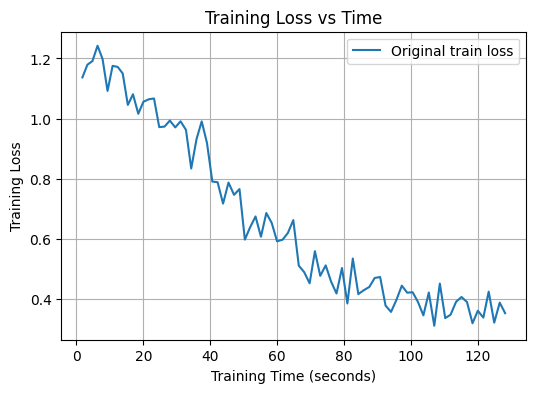

In [ ]:
from visualisation import plot_metric
plot_metric("train loss vs time", model_histories)

## Train model with attention from scratch

In [41]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_scratch = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("h5_files/500_covertype_database_100_80_rows_10_features.h5", num_steps=2000, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=7, 
            attention_type="Scratch"
        )
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories_scratch.append(history)

Finished iteration over all stored datasets! 
time     1.9s | loss  1.1479
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     3.4s | loss  1.1740
Finished iteration over all stored datasets! 
time     5.0s | loss  1.1923
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     6.5s | loss  1.2428
Finished iteration over all stored datasets! 
time     8.1s | loss  1.1996
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     9.7s | loss  1.1229
Finished iteration over all stored datasets! 
time    11.3s | loss  1.2062
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time    12.9s | loss  1.1903
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time    14.5s | loss  1.1897
Finished iteration over all stored datasets! 
time    16.1s | loss  1.0772
Finished iteration o

In [42]:
save_path = f"clean_models/nanotabpfn_scratch_attention.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_scratch:
    history.to_csv(f"clean_histories/nanotabpfn_scratch_attention.csv", index = False)

Saved model to clean_models/nanotabpfn_scratch_attention.pt


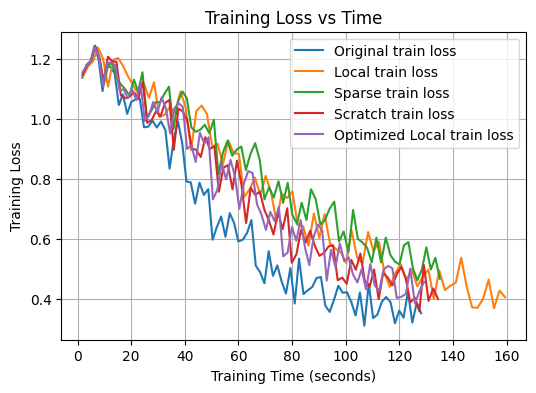

In [54]:
loaded_history_scratch = pd.read_csv("clean_histories/nanotabpfn_scratch_attention.csv")
model_histories["Scratch"] = loaded_history_scratch
plot_metric("train loss vs time", model_histories)

## Training a model with Sparse attention

In [37]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_sparse = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("h5_files/500_covertype_database_100_80_rows_10_features.h5", num_steps=2000, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=7, 
            attention_type= "Sparse"
        )
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories_sparse.append(history)

Finished iteration over all stored datasets! 
time     1.9s | loss  1.1443
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     3.5s | loss  1.1786
Finished iteration over all stored datasets! 
time     5.1s | loss  1.1921
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     6.7s | loss  1.2394
Finished iteration over all stored datasets! 
time     8.2s | loss  1.2024
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     9.8s | loss  1.1148
Finished iteration over all stored datasets! 
time    11.4s | loss  1.1782
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time    13.0s | loss  1.1850
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time    14.6s | loss  1.1352
Finished iteration over all stored datasets! 
time    16.2s | loss  1.1135
Finished iteration o

In [38]:
save_path = f"clean_models/nanotabpfn_sparse_attention.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_sparse:
    history.to_csv(f"clean_histories/nanotabpfn_sparse_attention.csv", index = False)

Saved model to clean_models/nanotabpfn_sparse_attention.pt


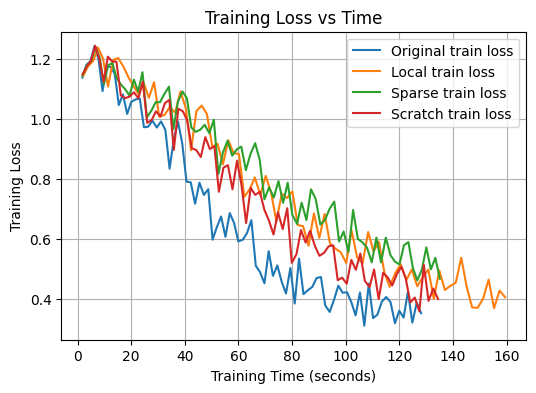

In [48]:
loaded_history_sparse = pd.read_csv("clean_histories/nanotabpfn_sparse_attention.csv")
model_histories["Sparse"] = loaded_history_sparse
plot_metric("train loss vs time", model_histories)

In [49]:
from visualisation import summarize_training_times_and_memory_usage
training_times_coverage = summarize_training_times_and_memory_usage(model_histories)
training_times_coverage

,model name,full training time,average step time,average mem per step,average peak mem per step
0,Original,128.098611,0.063643,22.828928,950.102336
1,Local,159.439931,0.079847,22.828928,1761.083136
2,Sparse,135.087237,0.067885,22.815104,1087.835776
3,Scratch,134.418065,0.067217,22.828928,1090.171392


## Local optimized attention

In [50]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_opt = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("h5_files/500_covertype_database_100_80_rows_10_features.h5", num_steps=2000, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=7, 
            attention_type= "Optimized Local"
        )
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories_opt.append(history)

Finished iteration over all stored datasets! 
time     1.8s | loss  1.1536
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     3.3s | loss  1.1764
Finished iteration over all stored datasets! 
time     4.9s | loss  1.1889
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     6.4s | loss  1.2390
Finished iteration over all stored datasets! 
time     8.0s | loss  1.2061
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time     9.5s | loss  1.1075
Finished iteration over all stored datasets! 
time    11.1s | loss  1.1855
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time    12.6s | loss  1.1863
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
time    14.1s | loss  1.1776
Finished iteration over all stored datasets! 
time    15.6s | loss  1.0948
Finished iteration o

In [51]:
save_path = f"clean_models/nanotabpfn_local_opt_attention.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_opt:
    history.to_csv(f"clean_histories/nanotabpfn_local_opt_attention.csv", index = False)

Saved model to clean_models/nanotabpfn_local_opt_attention.pt


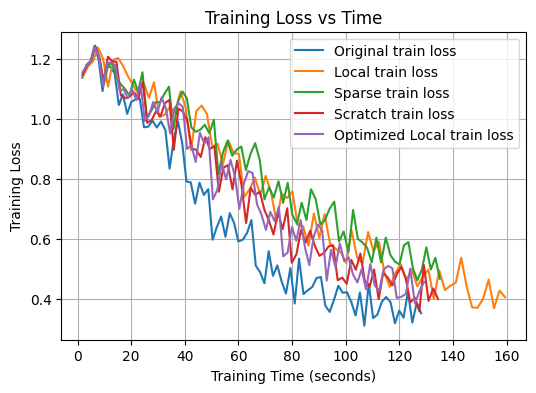

In [52]:
loaded_history_opt = pd.read_csv("clean_histories/nanotabpfn_local_opt_attention.csv")
model_histories["Optimized Local"] = loaded_history_opt
plot_metric("train loss vs time", model_histories)

In [53]:
training_times_coverage = summarize_training_times_and_memory_usage(model_histories)
training_times_coverage

,model name,full training time,average step time,average mem per step,average peak mem per step
0,Original,128.098611,0.063643,22.828928,950.102336
1,Local,159.439931,0.079847,22.828928,1761.083136
2,Sparse,135.087237,0.067885,22.815104,1087.835776
3,Scratch,134.418065,0.067217,22.828928,1090.171392
4,Optimized Local,129.222465,0.064653,22.828928,891.920032
